## Geneformer Fine-Tuning for Classification of Dosage-Sensitive vs. -Insensitive Transcription Factors (TFs)

In [1]:
import os
GPU_NUMBER = [0,1]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(s) for s in GPU_NUMBER])
os.environ["NCCL_DEBUG"] = "INFO"

In [ ]:
# imports
import datetime
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_from_disk
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, auc, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import StratifiedKFold
import torch
from transformers import BertForTokenClassification
from transformers import Trainer
from transformers.training_args import TrainingArguments
from tqdm.notebook import tqdm

import sys
sys.path.append('/ibex/user/chenj0i/Geneformer')
from geneformer import DataCollatorForGeneClassification
from geneformer.pretrainer import token_dictionary

from GF_CAB import CustomBertForMaskedLM

/ibex/user/chenj0i/pretrain_gf/lib/python3.11/site-packages/loompy/bus_file.py:67: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/ibex/user/chenj0i/pretrain_gf/lib/python3.11/site-packages/loompy/bus_file.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/ibex/user/chenj0i/pretrain_gf/lib/python3.11/site-packages/loompy/bus_file.py:101: NumbaDepreca

## Load Gene Attribute Information

In [ ]:
# table of corresponding Ensembl IDs, gene names, and gene types (e.g. coding, miRNA, etc.)
gene_info = pd.read_csv("example_input_files/gene_info_table.csv", index_col=0)

# create dictionaries for corresponding attributes
gene_id_type_dict = dict(zip(gene_info["ensembl_id"],gene_info["gene_type"]))
gene_name_id_dict = dict(zip(gene_info["gene_name"],gene_info["ensembl_id"]))
gene_id_name_dict = {v: k for k,v in gene_name_id_dict.items()}

## Model Directory

In [ ]:
model_path = 'model path'

## Load Training Data and Class Labels

In [5]:
# function for preparing targets and labels
def prep_inputs(genegroup1, genegroup2, id_type):
    if id_type == "gene_name":
        targets1 = [gene_name_id_dict[gene] for gene in genegroup1 if gene_name_id_dict.get(gene) in token_dictionary]
        targets2 = [gene_name_id_dict[gene] for gene in genegroup2 if gene_name_id_dict.get(gene) in token_dictionary]
    elif id_type == "ensembl_id":
        targets1 = [gene for gene in genegroup1 if gene in token_dictionary]
        targets2 = [gene for gene in genegroup2 if gene in token_dictionary]
            
    targets1_id = [token_dictionary[gene] for gene in targets1]
    targets2_id = [token_dictionary[gene] for gene in targets2]
    
    targets = np.array(targets1_id + targets2_id)
    labels = np.array([0]*len(targets1_id) + [1]*len(targets2_id))
    nsplits = min(5, min(len(targets1_id), len(targets2_id))-1)
    assert nsplits > 2
    print(f"# targets1: {len(targets1_id)}\n# targets2: {len(targets2_id)}\n# splits: {nsplits}")
    return targets, labels, nsplits

In [ ]:
# preparing targets and labels for dosage sensitive vs insensitive TFs
dosage_tfs = pd.read_csv("example_input_files/gene_classification/dosage_sensitive_tfs/dosage_sens_tf_labels.csv", header=0)
sensitive = dosage_tfs["dosage_sensitive"].dropna()
insensitive = dosage_tfs["dosage_insensitive"].dropna()
targets, labels, nsplits = prep_inputs(sensitive, insensitive, "ensembl_id")

# targets1: 122
# targets2: 368
# splits: 5


In [ ]:
# load training dataset
train_dataset=load_from_disk("Genecorpus-30M/genecorpus_30M_2048.dataset")
shuffled_train_dataset = train_dataset.shuffle(seed=42)
subsampled_train_dataset = shuffled_train_dataset.select([i for i in range(50_000)])

## Define Functions for Training and Cross-Validating Classifier

In [8]:
def preprocess_classifier_batch(cell_batch, max_len):
    if max_len == None:
        max_len = max([len(i) for i in cell_batch["input_ids"]])
    def pad_label_example(example):
        example["labels"] = np.pad(example["labels"], 
                                   (0, max_len-len(example["input_ids"])), 
                                   mode='constant', constant_values=-100)
        example["input_ids"] = np.pad(example["input_ids"], 
                                      (0, max_len-len(example["input_ids"])), 
                                      mode='constant', constant_values=token_dictionary.get("<pad>"))
        example["attention_mask"] = (example["input_ids"] != token_dictionary.get("<pad>")).astype(int)
        return example
    padded_batch = cell_batch.map(pad_label_example)
    return padded_batch

# forward batch size is batch size for model inference (e.g. 200)
def classifier_predict(model, evalset, forward_batch_size, mean_fpr):
    predict_logits = []
    predict_labels = []
    model.eval()
    
    # ensure there is at least 2 examples in each batch to avoid incorrect tensor dims
    evalset_len = len(evalset)
    max_divisible = find_largest_div(evalset_len, forward_batch_size)
    if len(evalset) - max_divisible == 1:
        evalset_len = max_divisible
    
    max_evalset_len = max(evalset.select([i for i in range(evalset_len)])["length"])
    
    for i in range(0, evalset_len, forward_batch_size):
        max_range = min(i+forward_batch_size, evalset_len)
        batch_evalset = evalset.select([i for i in range(i, max_range)])
        padded_batch = preprocess_classifier_batch(batch_evalset, max_evalset_len)
        padded_batch.set_format(type="torch")
        
        input_data_batch = padded_batch["input_ids"]
        attn_msk_batch = padded_batch["attention_mask"]
        label_batch = padded_batch["labels"]
        with torch.no_grad():
            outputs = model(
                input_ids = input_data_batch.to("cuda"), 
                attention_mask = attn_msk_batch.to("cuda"), 
                labels = label_batch.to("cuda"), 
            )
            predict_logits += [torch.squeeze(outputs.logits.to("cpu"))]
            predict_labels += [torch.squeeze(label_batch.to("cpu"))]
            
    logits_by_cell = torch.cat(predict_logits)
    all_logits = logits_by_cell.reshape(-1, logits_by_cell.shape[2])
    labels_by_cell = torch.cat(predict_labels)
    all_labels = torch.flatten(labels_by_cell)
    logit_label_paired = [item for item in list(zip(all_logits.tolist(), all_labels.tolist())) if item[1]!=-100]
    y_pred = [vote(item[0]) for item in logit_label_paired]
    y_true = [item[1] for item in logit_label_paired]
    logits_list = [item[0] for item in logit_label_paired]
    # probability of class 1
    y_score = [py_softmax(item)[1] for item in logits_list]
    conf_mat = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    # plot roc_curve for this split
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()
    # interpolate to graph
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return fpr, tpr, interp_tpr, conf_mat 

def vote(logit_pair):
    a, b = logit_pair
    if a > b:
        return 0
    elif b > a:
        return 1
    elif a == b:
        return "tie"
    
def py_softmax(vector):
	e = np.exp(vector)
	return e / e.sum()
    
# get cross-validated mean and sd metrics
def get_cross_valid_metrics(all_tpr, all_roc_auc, all_tpr_wt):
    wts = [count/sum(all_tpr_wt) for count in all_tpr_wt]
    print(wts)
    all_weighted_tpr = [a*b for a,b in zip(all_tpr, wts)]
    mean_tpr = np.sum(all_weighted_tpr, axis=0)
    mean_tpr[-1] = 1.0
    all_weighted_roc_auc = [a*b for a,b in zip(all_roc_auc, wts)]
    roc_auc = np.sum(all_weighted_roc_auc)
    roc_auc_sd = math.sqrt(np.average((all_roc_auc-roc_auc)**2, weights=wts))
    return mean_tpr, roc_auc, roc_auc_sd

# Function to find the largest number smaller
# than or equal to N that is divisible by k
def find_largest_div(N, K):
    rem = N % K
    if(rem == 0):
        return N
    else:
        return N - rem

In [ ]:
# cross-validate gene classifier
def cross_validate(data, targets, labels, nsplits, subsample_size, training_args, freeze_layers, output_dir, num_proc):
    # check if output directory already written to
    # ensure not overwriting previously saved model
    model_dir_test = os.path.join(output_dir, "ksplit0/models/pytorch_model.bin")
    if os.path.isfile(model_dir_test) == True:
        raise Exception("Model already saved to this directory.")
    
    # initiate eval metrics to return
    num_classes = len(set(labels))
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    all_roc_auc = []
    all_tpr_wt = []
    label_dicts = []
    confusion = np.zeros((num_classes,num_classes))
    
    # set up cross-validation splits
    skf = StratifiedKFold(n_splits=nsplits, random_state=0, shuffle=True)
    # train and evaluate
    iteration_num = 0
    for train_index, eval_index in tqdm(skf.split(targets, labels)):
        if len(labels) > 500:
            print("early stopping activated due to large # of training examples")
            nsplits = 3
            if iteration_num == 3:
                break
        print(f"****** Crossval split: {iteration_num}/{nsplits-1} ******\n")
        # generate cross-validation splits
        targets_train, targets_eval = targets[train_index], targets[eval_index]
        labels_train, labels_eval = labels[train_index], labels[eval_index]
        label_dict_train = dict(zip(targets_train, labels_train))
        label_dict_eval = dict(zip(targets_eval, labels_eval))
        label_dicts += (iteration_num, targets_train, targets_eval, labels_train, labels_eval)
        
        # function to filter by whether contains train or eval labels
        def if_contains_train_label(example):
            a = label_dict_train.keys()
            b = example['input_ids']
            return not set(a).isdisjoint(b)

        def if_contains_eval_label(example):
            a = label_dict_eval.keys()
            b = example['input_ids']
            return not set(a).isdisjoint(b)
        
        # filter dataset for examples containing classes for this split
        print(f"Filtering training data")
        trainset = data.filter(if_contains_train_label, num_proc=num_proc)
        print(f"Filtered {round((1-len(trainset)/len(data))*100)}%; {len(trainset)} remain\n")
        print(f"Filtering evalation data")
        evalset = data.filter(if_contains_eval_label, num_proc=num_proc)
        print(f"Filtered {round((1-len(evalset)/len(data))*100)}%; {len(evalset)} remain\n")

        # minimize to smaller training sample
        training_size = min(subsample_size, len(trainset))
        trainset_min = trainset.select([i for i in range(training_size)])
        eval_size = min(training_size, len(evalset))
        half_training_size = round(eval_size/2)
        evalset_train_min = evalset.select([i for i in range(half_training_size)])
        evalset_oos_min = evalset.select([i for i in range(half_training_size, eval_size)])
        
        # label conversion functions
        def generate_train_labels(example):
            example["labels"] = [label_dict_train.get(token_id, -100) for token_id in example["input_ids"]]
            return example

        def generate_eval_labels(example):
            example["labels"] = [label_dict_eval.get(token_id, -100) for token_id in example["input_ids"]]
            return example
        
        # label datasets 
        print(f"Labeling training data")
        trainset_labeled = trainset_min.map(generate_train_labels)
        print(f"Labeling evaluation data")
        evalset_train_labeled = evalset_train_min.map(generate_eval_labels)
        print(f"Labeling evaluation OOS data")
        evalset_oos_labeled = evalset_oos_min.map(generate_eval_labels)
        
        # create output directories
        ksplit_output_dir = os.path.join(output_dir, f"ksplit{iteration_num}")
        ksplit_model_dir = os.path.join(ksplit_output_dir, "models/") 
        
        # ensure not overwriting previously saved model
        model_output_file = os.path.join(ksplit_model_dir, "pytorch_model.bin")
        if os.path.isfile(model_output_file) == True:
            raise Exception("Model already saved to this directory.")

        # make training and model output directories
        os.makedirs(ksplit_output_dir, exist_ok=True)
        os.makedirs(ksplit_model_dir, exist_ok=True)
        
        # load model
        model = BertForTokenClassification.from_pretrained(
            model_path,
            num_labels=2,
            output_attentions = False,
            output_hidden_states = False
        )
        if freeze_layers is not None:
            modules_to_freeze = model.bert.encoder.layer[:freeze_layers]
            for module in modules_to_freeze:
                for param in module.parameters():
                    param.requires_grad = False

        #############
        pretrained_model = CustomBertForMaskedLM.from_pretrained(model_path)
        # Extract the word embeddings from the pretrained model
        pretrained_word_embeddings = pretrained_model.bert.embeddings.word_embeddings.weight.clone()
        model.bert.embeddings.word_embeddings.load_state_dict({"weight": pretrained_word_embeddings})    
        ###########  
  
        model = model.to("cuda:0")
        
        # add output directory to training args and initiate
        training_args["output_dir"] = ksplit_output_dir
        training_args_init = TrainingArguments(**training_args)
        
        # create the trainer
        trainer = Trainer(
            model=model,
            args=training_args_init,
            data_collator=DataCollatorForGeneClassification(),
            train_dataset=trainset_labeled,
            eval_dataset=evalset_train_labeled
        )

        # train the gene classifier
        trainer.train()
        
        # save model
        trainer.save_model(ksplit_model_dir)
        
        # evaluate model
        fpr, tpr, interp_tpr, conf_mat = classifier_predict(trainer.model, evalset_oos_labeled, 200, mean_fpr)
        
        # append to tpr and roc lists
        confusion = confusion + conf_mat
        all_tpr.append(interp_tpr)
        all_roc_auc.append(auc(fpr, tpr))
        # append number of eval examples by which to weight tpr in averaged graphs
        all_tpr_wt.append(len(tpr))
        
        iteration_num = iteration_num + 1
        
    # get overall metrics for cross-validation
    mean_tpr, roc_auc, roc_auc_sd = get_cross_valid_metrics(all_tpr, all_roc_auc, all_tpr_wt)
    return all_roc_auc, roc_auc, roc_auc_sd, mean_fpr, mean_tpr, confusion, label_dicts

## Define Functions for Plotting Results

In [10]:
# plot ROC curve
def plot_ROC(bundled_data, title):
    plt.figure()
    lw = 2
    for roc_auc, roc_auc_sd, mean_fpr, mean_tpr, sample, color in bundled_data:
        plt.plot(mean_fpr, mean_tpr, color=color,
                 lw=lw, label="{0} (AUC {1:0.2f} $\pm$ {2:0.2f})".format(sample, roc_auc, roc_auc_sd))
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
# plot confusion matrix
def plot_confusion_matrix(classes_list, conf_mat, title):
    display_labels = []
    i = 0
    for label in classes_list:
        display_labels += ["{0}\nn={1:.0f}".format(label, sum(conf_mat[:,i]))]
        i = i + 1
    display = ConfusionMatrixDisplay(confusion_matrix=preprocessing.normalize(conf_mat, norm="l1"), 
                                     display_labels=display_labels)
    display.plot(cmap="Blues",values_format=".2g")
    plt.grid(False)
    plt.title(title)

## Fine-Tune With Gene Classification Learning Objective and Quantify Predictive Performance

### Please note that, as usual with deep learning models, we **highly** recommend tuning learning hyperparameters for all fine-tuning applications as this can significantly improve model performance. Example hyperparameters are defined below, but please see the "hyperparam_optimiz_for_disease_classifier" script for an example of how to tune hyperparameters for downstream applications.

In [11]:
# set model parameters
# max input size
max_input_size = 2 ** 11  # 2048

# set training hyperparameters
# max learning rate
max_lr = 5e-5
# how many pretrained layers to freeze
freeze_layers = 4
# number gpus
num_gpus = 1
# number cpu cores
num_proc = 24
# batch size for training and eval
geneformer_batch_size = 12
# learning schedule
lr_schedule_fn = "linear"
# warmup steps
warmup_steps = 500
# number of epochs
epochs = 1
# optimizer
optimizer = "adamw"

In [14]:
# set training arguments
subsample_size = 10_000
training_args = {
    "learning_rate": max_lr,
    "do_train": True,
    "evaluation_strategy": "no",
    "save_strategy": "epoch",
    "logging_steps": 100,
    "group_by_length": True,
    "length_column_name": "length",
    "disable_tqdm": False,
    "lr_scheduler_type": lr_schedule_fn,
    "warmup_steps": warmup_steps,
    "weight_decay": 0.001,
    "per_device_train_batch_size": geneformer_batch_size,
    "per_device_eval_batch_size": geneformer_batch_size,
    "num_train_epochs": epochs,
    "report_to": "none",
}

In [15]:
# define output directory path
current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
training_output_dir = f"Downstream/previous/model_training_record/{datestamp}_geneformer_GeneClassifier_dosageTF_L{max_input_size}_B{geneformer_batch_size}_LR{max_lr}_LS{lr_schedule_fn}_WU{warmup_steps}_E{epochs}_O{optimizer}_n{subsample_size}_F{freeze_layers}/"

# ensure not overwriting previously saved model
ksplit_model_test = os.path.join(training_output_dir, "ksplit0/models/pytorch_model.bin")
if os.path.isfile(ksplit_model_test) == True:
    raise Exception("Model already saved to this directory.")

# make output directory
os.makedirs(training_output_dir, exist_ok=True)

In [ ]:
# cross-validate gene classifier
all_roc_auc, roc_auc, roc_auc_sd, mean_fpr, mean_tpr, confusion, label_dicts \
    = cross_validate(subsampled_train_dataset, targets, labels, nsplits, subsample_size, training_args, freeze_layers, training_output_dir, 1)

In [ ]:
# bundle data for plotting
bundled_data = []
bundled_data += [(roc_auc, roc_auc_sd, mean_fpr, mean_tpr, "Geneformer", "red")]

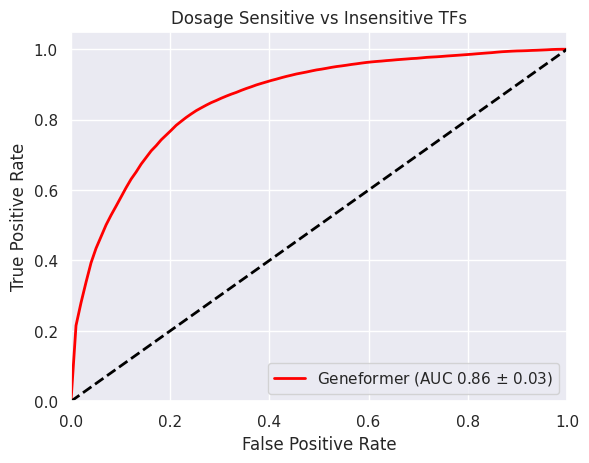

In [ ]:
# plot ROC curve
plot_ROC(bundled_data, 'Dosage Sensitive vs Insensitive TFs')

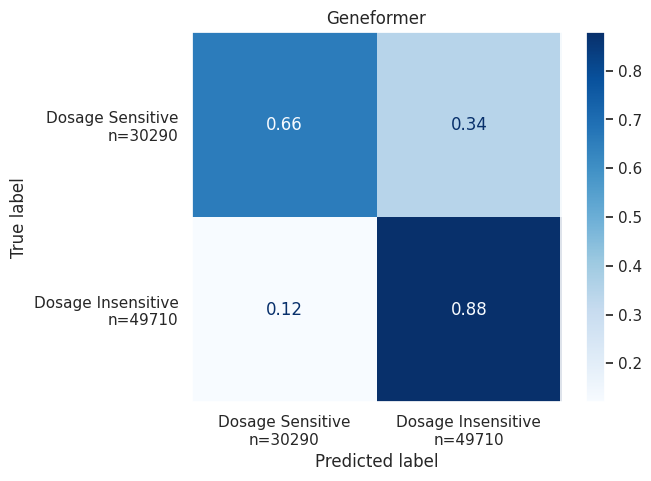

In [ ]:
# plot confusion matrix
classes_list = ["Dosage Sensitive", "Dosage Insensitive"]
plot_confusion_matrix(classes_list, confusion, "Geneformer")

In [ ]:
actual_totals = confusion.sum(axis=1)

# Compute correct predictions per class (diagonal)
correct_predictions = np.diag(confusion)

# Compute class-wise accuracies
class_accuracies = correct_predictions / actual_totals
# print(class_accuracies)

# Compute class weights (based on actual class frequency)
counting_num = confusion.sum(axis=0)
class_weights = counting_num / counting_num.sum()

# Compute weighted accuracy
weighted_accuracy = np.sum(class_weights * class_accuracies)

print(f"Weighted Accuracy: {weighted_accuracy}")

Weighted Accuracy: 0.7942145185000915
